# Δ‑Wave Explorer (v4) — Slopes, Inflections & Margin Curve

**One‑click Colab** notebook that:

1. Computes Δ(n) = |(i/2ⁿ)² – C| for φ, π, α, √3 / π, and 1/H₂…1/H₄ (n = 1…45).  
2. Visualises  
   * **log₁₀ Δ vs n** (decay slope)  
   * **Second finite difference** of log₁₀ Δ (wave / inflection detector)  
   * **Hit‑density vs ε** (ε ∈ 10⁻²…10⁻¹⁵)  
   * **Margin curve**: (α – control avg) hit‑count difference vs ε.  
3. Calculates shared metrics: median log₁₀ Δ (n ≥ 20) **and** linear‑fit slope of logΔ.  
4. Saves three CSVs (all Δ points, median table, slope table).

Open → **Runtime ▸ Run all** → ready in < 10 s on a free Colab CPU.


In [1]:
# ⬇️ Imports & constants
import mpmath as mp, numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from sklearn.linear_model import LinearRegression

mp.mp.dps = 40
MAX_BITS = 45

# Constants list
consts = [
    ('phi', (1 + mp.sqrt(5))/2),
    ('pi', mp.pi),
    ('alpha', mp.mpf(1)/mp.mpf('137.035999')),
    ('sqrt3_pi', mp.sqrt(3)/mp.pi),
]
def H(n): return mp.nsum(lambda k: 1/mp.mpf(k), [1, n])
consts += [(f'harm_{k}', 1/H(k)) for k in range(2,5)]
print('Constants:', ', '.join(name for name,_ in consts))


Constants: phi, pi, alpha, sqrt3_pi, harm_2, harm_3, harm_4


In [2]:
# ⚙️ Δ curves
def delta_curve(C):
    sqrtC = mp.sqrt(C)
    ns, ds = [], []
    for n in range(1, MAX_BITS+1):
        denom = mp.mpf(1 << n)
        i = mp.nint(sqrtC*denom)
        ds.append(float(abs((i/denom)**2 - C)))
        ns.append(n)
    return np.array(ns, int), np.array(ds, float)

curves = {name: delta_curve(c) for name,c in consts}


In [3]:
# 📊 Median & slope tables
summary, slopes = [], []
for name,(n,d) in curves.items():
    mask = n>=20
    median = np.median(np.log10(d[mask]))
    # slope via linear regression on logΔ between n 10–45
    sel = (n>=10)
    X = n[sel].reshape(-1,1)
    y = np.log10(d[sel])
    model = LinearRegression().fit(X,y)
    slopes.append((name, model.coef_[0]))
    summary.append((name, median))

median_df = pd.DataFrame(summary, columns=['constant','median_log10Δ_n≥20']).sort_values('median_log10Δ_n≥20')
slope_df  = pd.DataFrame(slopes,  columns=['constant','slope_logΔ'])

display(median_df); display(slope_df)


,constant,median_log10Δ_n≥20
2,alpha,-11.255932
5,harm_3,-10.949287
3,sqrt3_pi,-10.346128
6,harm_4,-10.203151
0,phi,-10.137798
4,harm_2,-10.090990
1,pi,-9.697622


,constant,slope_logΔ
0,phi,-0.304995
1,pi,-0.285546
2,alpha,-0.293491
3,sqrt3_pi,-0.301859
4,harm_2,-0.299317
5,harm_3,-0.306947
6,harm_4,-0.305529


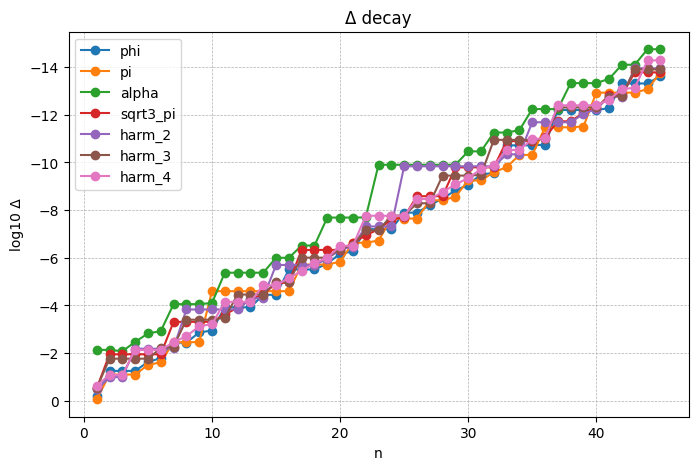

In [4]:
# Δ decay plot
plt.figure(figsize=(8,5))
for name,(n,d) in curves.items():
    plt.plot(n, np.log10(d), marker='o', label=name)
plt.gca().invert_yaxis(); plt.xlabel('n'); plt.ylabel('log10 Δ'); plt.title('Δ decay')
plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.show()


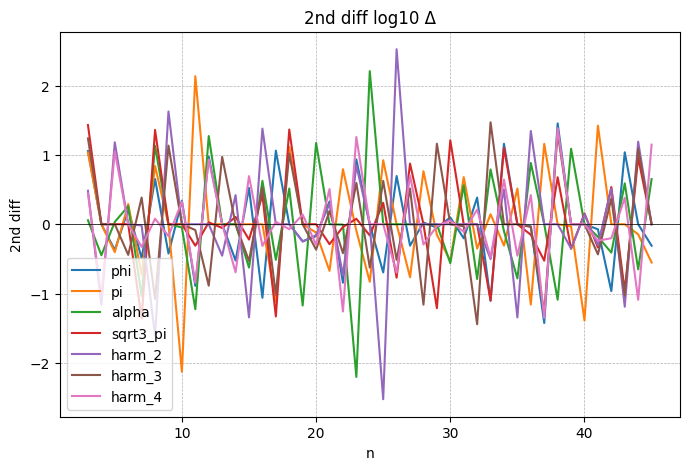

In [5]:
# Second finite diff
plt.figure(figsize=(8,5))
for name,(n,d) in curves.items():
    second = np.diff(np.log10(d), 2)
    plt.plot(n[2:], second, label=name)
plt.axhline(0, color='k', lw=0.5)
plt.title('2nd diff log10 Δ'); plt.xlabel('n'); plt.ylabel('2nd diff')
plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.show()


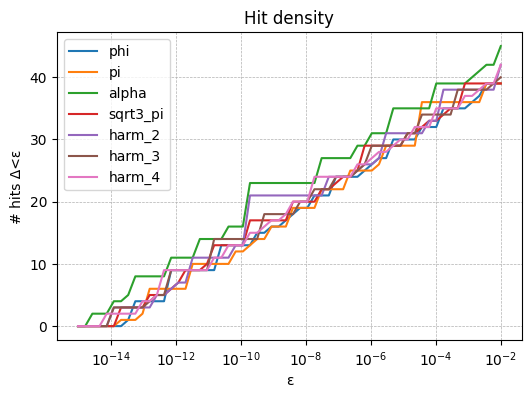

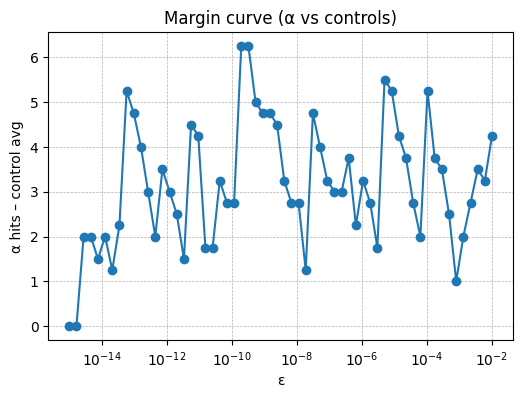

In [6]:
# Hit-density & margin curve
eps = np.logspace(-2,-15,60)
control_names = [name for name in curves if name.startswith('harm') or name=='sqrt3_pi']
alpha_hits = np.array([(curves['alpha'][1] < e).sum() for e in eps])
control_avg = np.mean([[(curves[c][1] < e).sum() for e in eps] for c in control_names], axis=0)
margin = alpha_hits - control_avg

plt.figure(figsize=(6,4))
for name,(n,d) in curves.items():
    counts=[(d<e).sum() for e in eps]
    plt.plot(eps, counts, label=name)
plt.xscale('log'); plt.xlabel('ε'); plt.ylabel('# hits Δ<ε'); plt.title('Hit density')
plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(eps, margin, marker='o')
plt.xscale('log'); plt.xlabel('ε'); plt.ylabel('α hits – control avg')
plt.title('Margin curve (α vs controls)'); plt.grid(True, ls='--', lw=0.5)
plt.show()


In [7]:
# 💾 save CSVs
rows=[]
for name,(n,d) in curves.items():
    for nn,dd in zip(n,d):
        rows.append((name, nn, dd))
all_df=pd.DataFrame(rows, columns=['constant','n','delta'])
ts=time.strftime('%Y%m%d_%H%M%S')
all_csv=f'delta_curves_{ts}.csv'; all_df.to_csv(all_csv,index=False)
median_df.to_csv(f'median_log_delta_{ts}.csv', index=False)
slope_df.to_csv(f'slope_log_delta_{ts}.csv', index=False)
print('Saved', all_csv, 'and summary CSVs.')


Saved delta_curves_20250716_122318.csv and summary CSVs.
